In [1]:
from os import listdir
from os.path import join, isfile
from typing import List

In [2]:
def get_data_from_file(path: str):
    with open(path, "r") as f:
        data: List[List[int]] = []
        lines = f.readlines()
        for line in lines:
            data.append([int(c) for c in line.split()])
        return data


def get_paths_of_dir(path: str, extension: str):
    return [join(path, f) for f in listdir(path)
            if isfile(join(path, f)) and f.endswith(extension)]

In [3]:
inDirPath = "../../Input/"
inPaths = get_paths_of_dir(inDirPath, extension=".in")

In [4]:
n_problem = int(input("Elige el problema (1-5): "))

inDirFiles = listdir(inDirPath)
file_name = inDirFiles[n_problem - 1]

path = inPaths[n_problem - 1]
prob = get_data_from_file(path)

In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

## Variable meanings.

* R = Number of rows.
* C = Number of columns.
* F = Number of vehicles.
* N = Pre-booked rides.
* B = Per-ride bonus for starting the ride on time.
* T = Simulation steps = distance between start and end.

In [6]:
# Problem data.
_, _, F, N, B, T = prob[0]

# Rides.
rides = prob[1:]

Bonus:
* Earn points proportional to distance of ride.
* Bonus if started on time. 

In [7]:
toolbox = base.Toolbox()

In [8]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

In [9]:
toolbox.register("attribute", random.randint, 0, F - 1)
toolbox.register("individual", tools.initRepeat,
                 creator.Individual, toolbox.attribute, n=N)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [10]:
def sort_rides(vehicle_rides):
    def sort_ride(ride):
        a, b, x, y, s, f = ride[1]
        origin = [a, b]
        destiny = [x, y]
        distance = dis(origin, destiny)

        return s + f - distance
    
    return sorted(vehicle_rides, key=lambda ride: sort_ride(ride))

def get_rides_from_ind(individual):
    vehicles_rides = np.full(F, None)
    
    for i, vehicle in enumerate(individual):
        v_r = vehicles_rides[vehicle]
        
        if v_r is None:
            v_r = []
            
        ride = rides[i]
        v_r.append([i, ride])
        
        vehicles_rides[vehicle] = v_r

    return vehicles_rides

def dis(a, b): return np.abs(a[0] - b[0]) + np.abs(a[1]-b[1])


In [11]:
def calc_fitness(car_rides):
    fitness = 0
    step = 0
    pos = [0, 0]
    
    # Sort car_rides given earliest time.
    car_rides = sort_rides(car_rides)

    for _, ride in car_rides:
        a, b, x, y, s, f = ride
        origin = [a, b]
        destiny = [x, y]
        earliest_start = s
        latest_finish = f
        
        # 1.- Go to origin.
        step += dis(pos, origin)
        
        # 2.- If arrived before the earliest time. Wait and earn bonus.
        if step <= earliest_start:
          fitness += B
          step = earliest_start
          
        # 3.- Go to destiny.
        dis_ori_des = dis(origin, destiny)
        step += dis_ori_des
        
        #4.- If reached destiny before latest finish. Earn points.
        if step <= latest_finish:
          fitness += dis_ori_des
          
        # 5.- Update position.
        pos = destiny
                  
        # 6.- Check if reached max distance with one vehicle.
        if step > T:
          break
    
    return fitness
        
def eval_ind(ind):
    all_rides = get_rides_from_ind(ind)

    fitness = 0

    for car_rides in all_rides:
        if car_rides is not None:
            fitness += calc_fitness(car_rides)

    return fitness,


In [12]:
NIND = 10

pop = toolbox.population(n=NIND)
print(f"Population: {pop}")

Population: [[24, 49, 11, 98, 47, 25, 27, 46, 52, 0, 39, 0, 38, 88, 75, 75, 50, 84, 0, 98, 11, 60, 41, 2, 42, 21, 53, 19, 79, 58, 97, 95, 85, 65, 45, 22, 74, 89, 0, 65, 37, 82, 9, 69, 54, 97, 66, 47, 80, 2, 32, 26, 54, 64, 27, 69, 82, 14, 41, 45, 71, 92, 71, 66, 74, 15, 87, 21, 82, 28, 73, 24, 71, 54, 81, 55, 87, 91, 9, 28, 43, 89, 70, 96, 89, 81, 47, 45, 31, 59, 8, 23, 69, 92, 85, 48, 61, 52, 43, 57, 36, 68, 24, 63, 75, 71, 33, 98, 60, 86, 14, 85, 18, 98, 95, 47, 28, 95, 95, 8, 22, 95, 89, 25, 60, 17, 39, 67, 72, 14, 54, 45, 74, 87, 66, 2, 88, 13, 8, 23, 83, 19, 93, 50, 2, 16, 94, 99, 62, 56, 71, 7, 1, 73, 59, 60, 44, 52, 28, 9, 30, 76, 89, 22, 10, 72, 79, 33, 94, 49, 30, 30, 36, 11, 0, 77, 8, 87, 65, 32, 90, 24, 83, 43, 77, 68, 49, 34, 80, 65, 30, 87, 78, 18, 71, 15, 86, 42, 94, 60, 95, 43, 23, 28, 56, 29, 18, 13, 89, 26, 86, 45, 72, 44, 67, 63, 53, 71, 68, 37, 88, 13, 6, 26, 83, 27, 49, 5, 53, 20, 78, 95, 33, 14, 99, 64, 31, 37, 12, 69, 86, 67, 35, 75, 24, 87, 35, 85, 53, 27, 63, 37

In [13]:
ind = toolbox.individual()

print("Individuo ANTES de evaluar")
print(ind)
print(ind.fitness.valid)
print("\n")

ind.fitness.values = eval_ind(ind)

print("Individuo TRAS evaluar")
print(ind)
print(ind.fitness.valid)
print(ind.fitness)

Individuo ANTES de evaluar
[56, 72, 44, 81, 19, 51, 17, 72, 86, 46, 85, 28, 93, 25, 15, 38, 50, 51, 49, 44, 15, 57, 2, 3, 79, 15, 73, 2, 69, 32, 71, 44, 92, 76, 41, 58, 84, 97, 42, 84, 42, 98, 27, 99, 23, 28, 86, 3, 79, 63, 5, 81, 42, 6, 25, 87, 80, 72, 1, 37, 35, 45, 50, 17, 4, 40, 50, 31, 90, 21, 85, 19, 58, 94, 19, 25, 59, 81, 19, 26, 92, 49, 91, 84, 24, 41, 81, 94, 97, 91, 76, 36, 57, 12, 64, 11, 49, 90, 11, 13, 22, 34, 43, 35, 34, 33, 21, 90, 16, 84, 50, 22, 20, 49, 18, 68, 75, 60, 0, 93, 64, 36, 21, 29, 13, 39, 32, 65, 97, 6, 16, 82, 50, 88, 43, 19, 55, 41, 70, 81, 98, 58, 26, 5, 97, 63, 2, 41, 54, 57, 84, 11, 47, 85, 82, 47, 80, 67, 75, 53, 19, 66, 83, 63, 61, 17, 15, 24, 22, 12, 1, 38, 73, 58, 12, 99, 9, 5, 29, 13, 25, 13, 9, 81, 27, 91, 15, 35, 28, 60, 80, 90, 60, 46, 1, 21, 44, 67, 94, 80, 64, 63, 52, 88, 54, 35, 74, 35, 54, 40, 6, 49, 31, 9, 49, 43, 58, 77, 49, 13, 89, 77, 27, 52, 15, 82, 73, 0, 99, 65, 19, 25, 44, 25, 0, 11, 23, 50, 90, 60, 36, 41, 42, 19, 92, 7, 28, 57, 47

In [14]:
TOURNSIZE, INDPB = 3, 0.2

toolbox.register("select", tools.selTournament, tournsize=TOURNSIZE)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=INDPB)
toolbox.register("evaluate", eval_ind)

In [15]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [19]:
CXPB, MUTPB, NGEN = 0.5, 0.0, 20

pop, logbook = algorithms.eaSimple(
    pop, toolbox, CXPB, MUTPB, NGEN, stats, verbose=False)

best_sol = tools.selBest(pop, 1)[0]

print(f"El resultado de la evolución es:")
print(logbook)
print(f"La mejor solucion encontrada es: {best_sol}")


[]

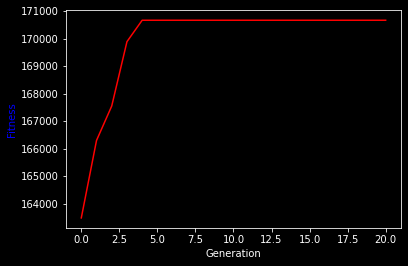

In [17]:
gen = logbook.select("gen")
avgs = logbook.select("avg")

fig = plt.figure()

ax = plt.gca()
line = ax.plot(gen, avgs, "r-", label="Average Fitness")
ax.set_xlabel("Generation")
ax.set_ylabel("Fitness", color="b")

plt.plot()

In [18]:
outDirPath = "../../Output/"
outFilePath = outDirPath + file_name.strip(".in") + ".out"

vehicles_rides = get_rides_from_ind(best_sol)

with open(outFilePath, "w") as f:
    for v_r in vehicles_rides:
      if v_r is None:
        f.write(str(0))
      else:
        v_r = sort_rides(v_r)    
        f.write(str(len(v_r)))
        f.write(" ")
        f.write(" ".join(str(pos) for pos, _ in v_r))
      
      f.write("\n")